In [1]:
#Script to analyze the results of the perturbation EBM run with forcings and feedbacks 
#diagnosed with Gregory regressions.

In [2]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
from voigtColors import voigtColors

/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [3]:
#Load TRACMIP results and EBM results (various EBM datasets with different diffusivities and eventually different feedbacks applied)
ds_GCM = xr.open_dataset('../nc_revised_20181130/master.nc')
ds_EBM = xr.open_dataset('nc_from_xarray/EBM_perturb_results_127e4.nc')
ds_EBM_106e4 = xr.open_dataset('nc_from_xarray/EBM_perturb_results_106e4.nc')
ds_EBM_096e4 = xr.open_dataset('nc_from_xarray/EBM_perturb_results_096e4.nc')

In [4]:
models = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1', 'ECHAM-6.3',
       'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT',
       'NorESM2']

legendText = ['AM2', 'CAM3', 'CAM4', 'CNRM-AM6-DIA-v2', 'ECHAM-6.1', 'ECHAM-6.3',
       'IPSL-CM5A', 'MIROC5', 'MPAS', 'MetUM-GA6-CTL', 'MetUM-GA6-ENT',
       'NorESM2', 'multi-model mean']


In [5]:
ds_GCM_anom = (ds_GCM.sel(exp='Aqua4xCO2')-ds_GCM.sel(exp='AquaControl')).mean(dim='time').mean(dim='lon')

/usr/local/python/anaconda3/envs/pangeo3.7/lib/python3.6/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [6]:
print(ds_EBM)

<xarray.Dataset>
Dimensions:             (lat: 180, model: 12)
Coordinates:
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * model               (model) object 'AM2' 'CAM3' ... 'NorESM2'
Data variables:
    CorrectedTransport  (model, lat) float64 ...
    Diffusion           (model, lat) float64 ...
    MSE                 (model, lat) float64 ...
    MSE_anom            (model, lat) float64 ...
    NorthTransport      (model, lat) float64 ...
    q                   (model, lat) float64 ...
    TS_perturb          (model, lat) float64 ...
    TS                  (model, lat) float64 ...


In [7]:

#####   PLOTS   #####


In [8]:
#Version for the runs with G = 0 ("noG"), i.e. assuming no change in ocean heat uptake 

In [9]:
#Load the data
ds_EBM_096e4_noG = xr.open_dataset('nc_from_xarray/EBM_perturb_results_noG_096e4.nc')

In [10]:
#Recalculate regional means

In [11]:
#Function for the regional means: (weighted by latitude--zonal mean already taken)

#Calculate an area weighted mean for subsetted zonal mean data, with lat/model dimensions
def areaWeightedMean(data):
    weights=np.cos(data.lat*np.pi/180.).values
    weighted = data*weights
    sumWeighted = weighted.sum(dim='lat')
    sumWeights = np.sum(weights)
    return sumWeighted/sumWeights

In [12]:
EBM_results_poleward_70 = ds_EBM_096e4_noG.sel(lat=ds_EBM_096e4_noG.lat[np.abs(ds_EBM_096e4_noG.lat)>70])['TS_perturb']
mean_poleward_70_EBM = areaWeightedMean(EBM_results_poleward_70)

In [13]:
EBM_results_within_30 = ds_EBM_096e4_noG.sel(lat=ds_EBM_096e4_noG.lat[np.abs(ds_EBM_096e4_noG.lat)<70])['TS_perturb']
mean_within_30_EBM = areaWeightedMean(EBM_results_within_30)

In [14]:
diff_GCM = (ds_GCM.sel(exp='Aqua4xCO2')['ts'].mean(dim='time').mean(dim='lon') - 
            ds_GCM.sel(exp='AquaControl')['ts'].mean(dim='time').mean(dim='lon'))

In [15]:
GCM_results_poleward_70 = diff_GCM.sel(lat=diff_GCM.lat[np.abs(diff_GCM.lat)>70])
mean_poleward_70_GCM = areaWeightedMean(GCM_results_poleward_70)

GCM_results_within_30 = diff_GCM.sel(lat=diff_GCM.lat[np.abs(diff_GCM.lat)<70])
mean_within_30_GCM = areaWeightedMean(GCM_results_within_30)

In [16]:
#Global mean warming for polar amplification
GM_EBM = areaWeightedMean(ds_EBM_096e4_noG['TS_perturb'])
GM_GCM = areaWeightedMean(diff_GCM)

In [17]:
polar_amp_EBM = mean_poleward_70_EBM/GM_EBM
polar_amp_GCM = mean_poleward_70_GCM/GM_GCM

In [18]:
def setuppanel_zonalmean(ax, title, ylabel = 'Temperature anomaly (K)', ylims='default', equator=False):
    plt.hlines(0, -1, 1, linestyles='dashed') #zero line
    ax.set_xticks([-.866, -.5, 0, .5, .866])
    ax.xaxis.set_ticklabels(['-60$\degree$', '-30$\degree$', '0$\degree$', '30$\degree$', '60$\degree$'])
    ax.tick_params(labelsize=12)
    plt.xlabel('Latitude', fontsize=11)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title, fontsize=12)
    ax.set_xlim([-1.03,1.02])
    if not ylims=='default':
        ax.set_ylim(ylims)
    if equator:
        plt.vlines(0, ax.get_ylim()[0], ax.get_ylim()[1], linestyles='dashed', linewidth=0.5) 

In [19]:
#Calculate correlation coefficient, print in bottom right corner and return

def scatter_EBM_GCM_v2(ds_EBM, ds_GCM, models, lims='auto', legend=True, loc=0, axlabel='', printcorr=True):
    legendEntries = dict()
    points_EBM = np.zeros(len(models))
    points_GCM = np.zeros(len(models))
    i = 0
    for model in models:
        legendEntries[model] = plt.scatter(ds_EBM.sel(model=model),
                                           ds_GCM.sel(model=model),
                                           c=voigtColors[model],s=100)
        points_EBM[i] = ds_EBM.sel(model=model)
        points_GCM[i] = ds_GCM.sel(model=model)
        i = i + 1
    plt.xlabel(axlabel+'MEBM', fontsize=12)
    plt.ylabel(axlabel+'GCMs', fontsize=12)
    corr = np.corrcoef(points_EBM, points_GCM)[0,1]
    if legend:
        plt.legend(legendEntries, loc=loc, frameon=False)
    if not lims=='auto': #Specify x and y limits, and plot 1:1 line, and print correlation coefficient
        plt.axis(lims)
        plt.plot([min(lims), max(lims)], [min(lims), max(lims)], linestyle='dashed') 
        if printcorr:
            boxwidth = max(lims)-min(lims)
            plt.text(max(lims)-0.25*boxwidth, min(lims)+0.05*boxwidth, 'r = {0:.3f}'.format(corr), fontsize=12)
    ax.tick_params(labelsize=12)
    return corr

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

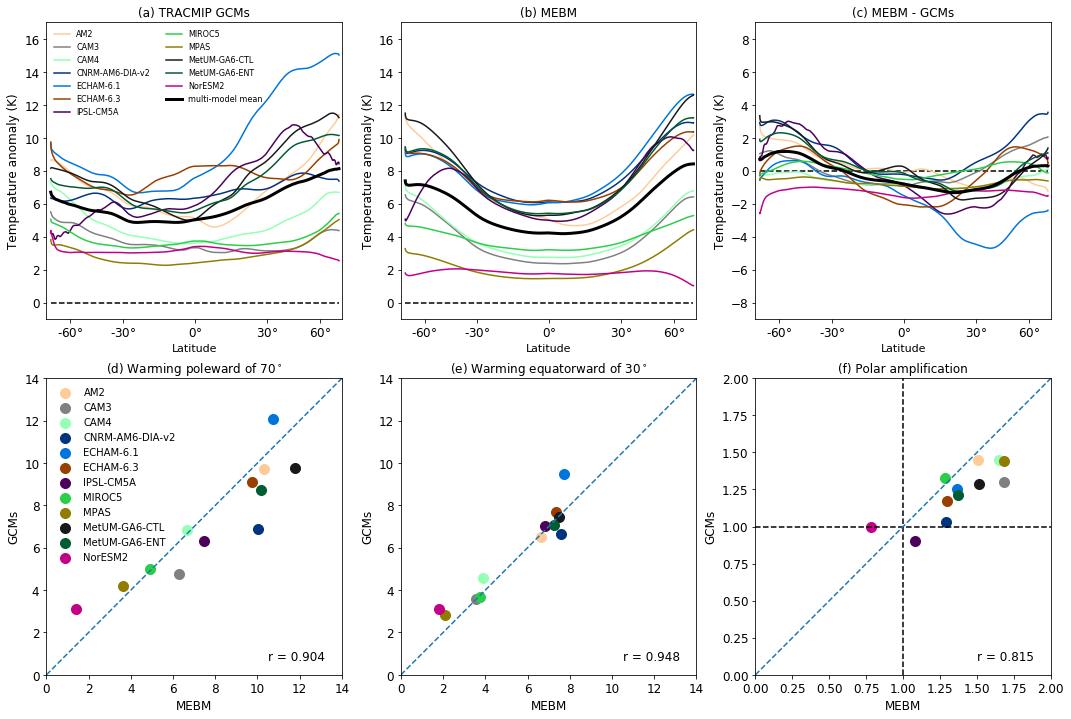

In [20]:

plt.figure(figsize=(18,12))

#Top row
ax = plt.subplot(2,3,1)
for model in models:
    plotdata = (ds_GCM.sel(model=model, exp='Aqua4xCO2')['ts'].mean(dim='time').mean(dim='lon') -
                ds_GCM.sel(model=model, exp='AquaControl')['ts'].mean(dim='time').mean(dim='lon'))
    plt.plot(np.sin(ds_GCM.lat*np.pi/180.), plotdata, color=voigtColors[model], linewidth=1.5)
plotdata_mmm = (ds_GCM.sel(model=models, exp='Aqua4xCO2')['ts'].mean(dim='time').mean(dim='lon') - 
                ds_GCM.sel(model=models, exp='AquaControl')['ts'].mean(dim='time').mean(dim='lon')).mean(dim='model')
plt.plot(np.sin(ds_GCM.lat*np.pi/180.), plotdata_mmm, color='k', linewidth=3)
setuppanel_zonalmean(ax, '(a) TRACMIP GCMs', ylims=[-1, 17])
plt.legend(legendText, loc='upper left', ncol=2, fontsize=8, frameon=False)

ax = plt.subplot(2,3,2)
for model in models:
    plotdata = ds_EBM_096e4_noG.sel(model=model)['TS_perturb']
    plt.plot(np.sin(ds_GCM.lat*np.pi/180.), plotdata, color=voigtColors[model], linewidth=1.5)
plt.plot(np.sin(ds_GCM.lat*np.pi/180.), ds_EBM_096e4_noG['TS_perturb'].mean(dim='model'), color='k', linewidth=3)
setuppanel_zonalmean(ax, '(b) MEBM', ylims=[-1, 17])

ax = plt.subplot(2,3,3)
for model in models:
    plotdata = (ds_EBM_096e4_noG.sel(model=model)['TS_perturb'] -
                (ds_GCM.sel(model=model, exp='Aqua4xCO2')['ts'].mean(dim='time').mean(dim='lon') - 
                 ds_GCM.sel(model=model, exp='AquaControl')['ts'].mean(dim='time').mean(dim='lon')))
    plt.plot(np.sin(ds_GCM.lat*np.pi/180.), plotdata, color=voigtColors[model], linewidth=1.5)
plt.plot(np.sin(ds_GCM.lat*np.pi/180.), ds_EBM_096e4_noG['TS_perturb'].mean(dim='model') - plotdata_mmm, color='k', linewidth=3)
setuppanel_zonalmean(ax, '(c) MEBM - GCMs', ylims=[-9,9])

#Bottom row
ax = plt.subplot(2,3,4)
scatter_EBM_GCM_v2( mean_poleward_70_EBM, mean_poleward_70_GCM, models, lims=[0, 14, 0, 14])
plt.title('(d) Warming poleward of 70$^\circ$', fontsize=12)

ax = plt.subplot(2,3,5)
scatter_EBM_GCM_v2( mean_within_30_EBM, mean_within_30_GCM, models, lims=[0, 14, 0, 14], legend=False)
plt.title('(e) Warming equatorward of 30$^\circ$', fontsize=12)
#scatter_EBM_GCM_v2([''])

ax = plt.subplot(2,3,6)
scatter_EBM_GCM_v2(polar_amp_EBM, polar_amp_GCM, models, lims=[0, 2, 0, 2], legend=False)
plt.title('(f) Polar amplification', fontsize=12)
plt.hlines(1, 0, 2, linestyles='dashed') #line showing whether models are polar amplified
plt.vlines(1, 0, 2, linestyles='dashed')

#Need a legend somewhere on top row 

#Bottom row: new scatter plots with correlation coefficients
plt.savefig('plots/Figure1_noG.pdf')
plt.savefig('plots/Figure1_noG.png', dpi=200)